# Import

In [214]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import random
import matplotlib.patheffects as PathEffects
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, silhouette_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

In [8]:
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [9]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import optimizers, layers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, save_model, Sequential   #to create hirachical layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import LeakyReLU, Multiply, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
train_filename = './data/new_mimic_train.tfrecords'
val_filename = './data/new_mimic_val.tfrecords'
test_filename = './data/new_mimic_test.tfrecords'
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
BUFFER_SIZE = 1000
BATCH_SIZE = 16
ALPHA = 0.2
current_group = None

In [12]:
feature_description = {
    'jpg_bytes': tf.io.FixedLenFeature([], tf.string),
    'race': tf.io.FixedLenFeature([], tf.int64),
    'age': tf.io.FixedLenFeature([], tf.int64),
    'gender': tf.io.FixedLenFeature([], tf.int64),
    'subject_id': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.float32),
    'Consolidation': tf.io.FixedLenFeature([], tf.float32),
    'Edema': tf.io.FixedLenFeature([], tf.float32),
    'Enlarged Cardiomediastinum': tf.io.FixedLenFeature([], tf.float32),
    'Lung Opacity': tf.io.FixedLenFeature([], tf.float32),
    'Atelectasis': tf.io.FixedLenFeature([], tf.float32),
    'No Finding': tf.io.FixedLenFeature([], tf.float32),
    'Pleural Effusion': tf.io.FixedLenFeature([], tf.float32),
    'Pneumonia': tf.io.FixedLenFeature([], tf.float32),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.float32)
}

label_list = ['Pneumothorax', 'Pneumonia', 'Pleural Effusion', 'No Finding', 'Atelectasis', 'Lung Opacity','Enlarged Cardiomediastinum', 'Edema', 'Consolidation', 'Cardiomegaly']

# Preprocess

In [61]:
data_train = tf.data.TFRecordDataset(train_filename)
img_train, label_train, sid, age, gender, race = [], [], [], [], [], []
for raw_record in tqdm(data_train):

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    # nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
    # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    
    label_train.append(0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1)
    img_train.append(example.features.feature['jpg_bytes'].bytes_list.value[0])
    sid.append(example.features.feature['subject_id'].int64_list.value[0])
    age.append(example.features.feature['age'].int64_list.value[0])
    gender.append(example.features.feature['gender'].int64_list.value[0])
    race.append(example.features.feature['race'].int64_list.value[0])


64955it [01:22, 791.95it/s] 


In [97]:
def _parse(example):
    return tf.io.parse_single_example(example, feature_description)
def apply(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.image.decode_jpeg(example['jpg_bytes'], channels=3)
    labels = [tf.cast(0, tf.int32) if example['No Finding'] == 1 else tf.cast(1, tf.int32)]
    return img, labels

def _fixup_shape(images, labels, groups):
    images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, 3])
    labels.set_shape([1])
    return images, labels

In [98]:
def load_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    # dataset = dataset.map(_parse)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [99]:
dataset_test = load_dataset(test_filename)

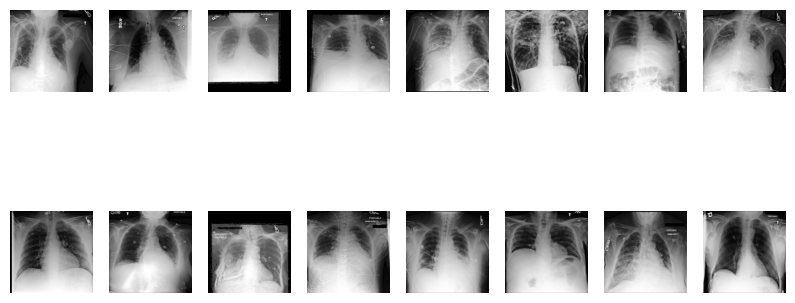

In [100]:
plt.figure(figsize=(10, 10))
for img, label in dataset_test.take(1):
    for n in range(16):
        ax = plt.subplot(4, 8, n+1)
        plt.imshow(img[n], cmap='gray')
        plt.axis("off")

# Create Batch

In [101]:
idx_list = [i for i in range(len(label_train))]
label_train = np.array(label_train)
img_train = np.array(img_train)
sid = np.array(sid)
age = np.array(age)
gender = np.array(gender)

In [102]:
idx = np.random.randint(0, img_train.shape[0] - 1)
            
sub_id = sid[idx]
label_anchor = label_train[idx]
age_anchor = age[idx]

idx_neg = np.squeeze([np.where(label_train != label_anchor)])
idx_neg1 = np.squeeze([np.where((label_train != label_anchor) & (age == age_anchor))])
idx_pos = np.squeeze([np.where(label_train == label_anchor)])

In [103]:
np.squeeze([np.where((label_train != label_anchor) & (age == 2))])

array([    0,    53,    57, ..., 64944, 64945, 64946], dtype=int64)

In [104]:
# # current group race
# idx_list = [i for i in range(len(label_train))]
# label_train = np.array(label_train)
# img_train = np.array(img_train)
# sid = np.array(sid)
# age = np.array(age)
# gender = np.array(gender)
# race = np.array(race)
# random.seed(80)

# idx_list1 = np.squeeze(np.where((label_train==0) & (race == 4)))
# idx_list2 = np.squeeze(np.where((label_train==1) & (race == 4)))
# def create_batch(have_used, BATCH_SIZE = 16):
#     img_anchors, img_positives, img_negatives = [], [], []
#     mask_anchors, mask_positives, mask_negatives = [], [], []
#     for i in range(BATCH_SIZE):
#         while True:
#             p_anchor =  np.random.uniform(0, 1, 1)[0]
#             while True:
#                 idx = np.random.randint(0, img_train.shape[0] - 1)
#                 if p_anchor < 0.2:
#                     if p_anchor < 0.1:
#                         idx = idx_list1[np.random.randint(0, idx_list1.shape[0] - 1)]
#                         break
#                     elif p_anchor >= 0.1:
#                         idx = idx_list2[np.random.randint(0, idx_list2.shape[0] - 1)]
#                         break
#                 else:
#                     break
            
#             sub_id = sid[idx]
#             label_anchor = label_train[idx]
#             race_anchor = race[idx]
            
#             idx_neg = np.squeeze([np.where(label_train != label_anchor)])
#             idx_neg1 = np.squeeze([np.where((label_train != label_anchor) & (race == race_anchor))])
#             idx_neg2 = np.squeeze([np.where((label_train != label_anchor) & (race != race_anchor))])
            
#             idx_pos = np.squeeze([np.where(label_train == label_anchor)])
#             idx_pos1 = np.squeeze([np.where((label_train == label_anchor) & (race == race_anchor))])
#             idx_pos2 = np.squeeze([np.where((label_train == label_anchor) & (race != race_anchor))])
            
#             p = np.random.uniform(0, 1, 1)[0]
            
#             if p > 0.2:
#                 neg_idx = idx_neg1[np.random.randint(0, idx_neg1.shape[0] - 1)]
#             else: 
#                 neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                
#             while True:       
#                 if p > 0.2:
#                     pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
#                 else: 
#                     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
                    
#                 if sid[pos_idx] != sub_id:
#                     break
                    
#             if (pos_idx, neg_idx) not in have_used.get(sub_id, []):
#                 break
        
#         if have_used.get(sub_id, 0) == 0:
#             have_used[sub_id] = []
#         else:
#             have_used[sub_id].append((pos_idx, neg_idx))
            
#         if have_used.get(sid[pos_idx], 0) == 0:
#             have_used[sid[pos_idx]] = []
#         else:
#             have_used[sid[pos_idx]].append((idx, neg_idx))
            
#         img_anchor = apply(img_train[idx])
#         img_pos = apply(img_train[pos_idx])
#         img_neg = apply(img_train[neg_idx])
        
#         img_anchors.append(img_anchor)
#         img_positives.append(img_pos)
#         img_negatives.append(img_neg)
#     return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
        
# used = {}
# img, img_pos, img_neg = create_batch(used, 8)

In [105]:
# # current group sex
# idx_list = [i for i in range(len(label_train))]
# label_train = np.array(label_train)
# img_train = np.array(img_train)
# sid = np.array(sid)
# age = np.array(age)
# gender = np.array(gender)
# random.seed(80)

# def create_batch(have_used, BATCH_SIZE = 16):
#     img_anchors, img_positives, img_negatives = [], [], []
#     mask_anchors, mask_positives, mask_negatives = [], [], []
#     for i in range(BATCH_SIZE):
#         while True:
#             idx = np.random.randint(0, img_train.shape[0] - 1)
            
#             sub_id = sid[idx]
#             label_anchor = label_train[idx]
#             gender_anchor = gender[idx]
            
#             idx_neg = np.squeeze([np.where(label_train != label_anchor)])
#             idx_neg1 = np.squeeze([np.where((label_train != label_anchor) & (gender == gender_anchor))])
#             idx_neg2 = np.squeeze([np.where((label_train != label_anchor) & (gender != gender_anchor))])
            
#             idx_pos = np.squeeze([np.where(label_train == label_anchor)])
#             idx_pos1 = np.squeeze([np.where((label_train == label_anchor) & (gender == gender_anchor))])
#             idx_pos2 = np.squeeze([np.where((label_train == label_anchor) & (gender != gender_anchor))])
            
#             p = np.random.uniform(0, 1, 1)[0]
            
#             if p > 0.2:
#                 neg_idx = idx_neg1[np.random.randint(0, idx_neg1.shape[0] - 1)]
#             else: 
#                 neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                
#             while True:       
#                 if p > 0.2:
#                     pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
#                 else: 
#                     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
                    
#                 if sid[pos_idx] != sub_id:
#                     break
                    
#             if (pos_idx, neg_idx) not in have_used.get(sub_id, []):
#                 break
        
#         if have_used.get(sub_id, 0) == 0:
#             have_used[sub_id] = []
#         else:
#             have_used[sub_id].append((pos_idx, neg_idx))
            
#         if have_used.get(sid[pos_idx], 0) == 0:
#             have_used[sid[pos_idx]] = []
#         else:
#             have_used[sid[pos_idx]].append((idx, neg_idx))
            
#         img_anchor = apply(img_train[idx])
#         img_pos = apply(img_train[pos_idx])
#         img_neg = apply(img_train[neg_idx])
        
#         img_anchors.append(img_anchor)
#         img_positives.append(img_pos)
#         img_negatives.append(img_neg)
#     return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
# used = {}
# img, img_pos, img_neg = create_batch(used, 8)

In [106]:
## current group age
# idx_list = [i for i in range(len(label_train))]
# label_train = np.array(label_train)
# img_train = np.array(img_train)
# sid = np.array(sid)
# age = np.array(age)
# random.seed(80)

# idx_list1 = np.squeeze(np.where((label_train==0) & (age == 0)))
# idx_list2 = np.squeeze(np.where((label_train==1) & (age == 0)))
# def create_batch(have_used, BATCH_SIZE = 16):
#     img_anchors, img_positives, img_negatives = [], [], []
#     mask_anchors, mask_positives, mask_negatives = [], [], []
#     for i in range(BATCH_SIZE):
#         while True:
#             p_anchor =  np.random.uniform(0, 1, 1)[0]
#             while True:
#                 idx = np.random.randint(0, img_train.shape[0] - 1)
#                 if p_anchor < 0.2:
#                     if p_anchor < 0.1:
#                         idx = idx_list1[np.random.randint(0, idx_list1.shape[0] - 1)]
#                         break
#                     elif p_anchor >= 0.1:
#                         idx = idx_list2[np.random.randint(0, idx_list2.shape[0] - 1)]
#                         break
#                 else:
#                     break
            
#             sub_id = sid[idx]
#             label_anchor = label_train[idx]
#             age_anchor = age[idx]
            
#             idx_neg = np.squeeze([np.where(label_train != label_anchor)])
#             idx_neg1 = np.squeeze([np.where((label_train != label_anchor) & (age == age_anchor))])
#             idx_neg2 = np.squeeze([np.where((label_train != label_anchor) & (age != age_anchor))])
            
#             idx_pos = np.squeeze([np.where(label_train == label_anchor)])
#             idx_pos1 = np.squeeze([np.where((label_train == label_anchor) & (age == age_anchor))])
#             idx_pos2 = np.squeeze([np.where((label_train == label_anchor) & (age != age_anchor))])
            
#             p = np.random.uniform(0, 1, 1)[0]
            
#             if p > 0.2:
#                 neg_idx = idx_neg1[np.random.randint(0, idx_neg1.shape[0] - 1)]
#             else: 
#                 neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                
#             while True:       
#                 if p > 0.2:
#                     pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
#                 else: 
#                     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
                    
#                 if sid[pos_idx] != sub_id:
#                     break
                    
#             if (pos_idx, neg_idx) not in have_used.get(sub_id, []):
#                 break
        
#         if have_used.get(sub_id, 0) == 0:
#             have_used[sub_id] = []
#         else:
#             have_used[sub_id].append((pos_idx, neg_idx))
            
#         if have_used.get(sid[pos_idx], 0) == 0:
#             have_used[sid[pos_idx]] = []
#         else:
#             have_used[sid[pos_idx]].append((idx, neg_idx))
            
#         img_anchor = apply(img_train[idx])
#         img_pos = apply(img_train[pos_idx])
#         img_neg = apply(img_train[neg_idx])
        
#         img_anchors.append(img_anchor)
#         img_positives.append(img_pos)
#         img_negatives.append(img_neg)
#     return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
        
# used = {}
# img, img_pos, img_neg = create_batch(used, 8)

In [107]:
# current group none
idx_list = [i for i in range(len(label_train))]
label_train = np.array(label_train)
img_train = np.array(img_train)
sid = np.array(sid)
random.seed(80)

def create_batch(have_used, BATCH_SIZE = 16):
    img_anchors, img_positives, img_negatives = [], [], []
    mask_anchors, mask_positives, mask_negatives = [], [], []
    for i in range(BATCH_SIZE):
        while True:
            idx = np.random.randint(0, img_train.shape[0] - 1)
            
            sub_id = sid[idx]
            label_anchor = label_train[idx]
            
            idx_neg = np.squeeze([np.where(label_train != label_anchor)])
            idx_pos = np.squeeze([np.where(label_train == label_anchor)])
            
            p = np.random.uniform(0, 1, 1)[0]
            
            neg_idx = idx_neg[np.random.randint(0, idx_neg.shape[0] - 1)]
                
            while True:       
                pos_idx = idx_pos[np.random.randint(0, idx_pos.shape[0] - 1)]
                if sid[pos_idx] != sub_id:
                    break
                    
            if (pos_idx, neg_idx) not in have_used.get(sub_id, []):
                break
        
        if have_used.get(sub_id, 0) == 0:
            have_used[sub_id] = []
        else:
            have_used[sub_id].append((pos_idx, neg_idx))
            
        if have_used.get(sid[pos_idx], 0) == 0:
            have_used[sid[pos_idx]] = []
        else:
            have_used[sid[pos_idx]].append((idx, neg_idx))
            
        img_anchor = apply(img_train[idx])
        img_pos = apply(img_train[pos_idx])
        img_neg = apply(img_train[neg_idx])
        
        img_anchors.append(img_anchor)
        img_positives.append(img_pos)
        img_negatives.append(img_neg)
    return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
used = {}
img, img_pos, img_neg = create_batch(used, 16)

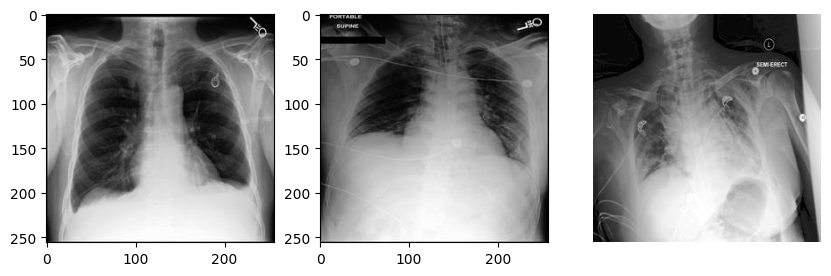

In [108]:
plt.figure(figsize=(10, 10))
for img1, img2, img3 in zip(img, img_pos, img_neg):
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img1)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(img2)
    ax = plt.subplot(1, 3, 3)
    plt.imshow(img3)
    plt.axis("off")
    break

# Model

In [109]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
input_img = Input(input_shape)
x = tf.keras.applications.densenet.preprocess_input(input_img)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor = x, pooling = 'avg')
x = base_model(x)
x = Dense(units=256, activation='relu')(x)
embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
model = Model(inputs=input_img, outputs=embedding)

In [110]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
lambda_2 (Lambda)            (None, 256)               0   

In [111]:
def triplet_loss(anchor, positive, negative):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis = 1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis = 1)
    loss = tf.maximum(pos_dist - neg_dist + ALPHA, 0.0)
    return tf.reduce_mean(loss)
    # return loss

def test_acc(epoch):
    unique_sid = set()
    x_train, y_train, x_val, y_val = [], [], [], []
    for i in tqdm(range(len(img_train))):
        if sid[i] in unique_sid:
            continue
        unique_sid.add(sid[i])
        imgAnc = apply(img_train[i])
        imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
        # maskAnc = np.expand_dims(np.array(maskAnc), axis = 0)
        embedding = model(imgAnc, training = False)
        x_train.append(embedding)
        y_train.append(label_train[i])
    
    for i in tqdm(range(len(img_val))):
        imgAnc = apply(img_val[i])
        imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
        embedding = model(imgAnc, training = False)
        x_val.append(embedding)
        y_val.append(label_val[i])
    
    rf = RandomForestClassifier(n_estimators=500, random_state=8042)
    rf.fit(np.squeeze(x_train, axis = 1), y_train)
    train_preds = rf.predict(np.squeeze(x_train, axis = 1))
    preds = rf.predict(np.squeeze(x_val, axis = 1))
    
    return accuracy_score(y_train, train_preds), accuracy_score(y_val, preds)

## Training

In [112]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True
)
optimizer=keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9)

prev = 0

@tf.function
def train_step(anc, pos, neg):
    with tf.GradientTape() as tape:
        anchor = model(anc, training = True)
        positive = model(pos, training = True)
        negative = model(neg, training = True)
        
        loss = triplet_loss(anchor, positive, negative)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss

@tf.function
def test_step(anc, pos, neg):
    imgAnc, maskAnc = anc
    imgPos, maskPos = pos
    imgNeg, maskNeg = neg
    anchor = model(imgAnc, maskAnc, training = False)
    positive = model(imgPos, maskPos, training = False)
    negative = model(imgNeg, maskNeg, training = False)
        
    loss = triplet_loss(anchor, positive, negative)
    
    return loss


epochs = 20
count = 0
prev_loss = 1
steps = int(len(img_train)/BATCH_SIZE)
for epoch in range(epochs):
    print('Start of epoch: ', epoch)
    train_loss, val_loss = 0, 0
    used = {}
    for step in tqdm(range(steps)):
        anc, pos, neg = create_batch(used, BATCH_SIZE)
        train_loss += train_step(anc, pos, neg)
        
    print('epoch {}, train_loss = {}'.format(epoch, train_loss/steps))
    
    acc, val_acc = test_acc(epoch)
    # val_acc = test_acc(epoch)

    print('epoch {}, train_acc = {}, val_acc = {}'.format(epoch, acc, val_acc))
    
    if val_acc > prev:
        prev = val_acc
        print('save acc: {}'.format(val_acc))
        if current_group == None:
            model.save_weights("./model/siamese/rf_siamese_1")
        else:
            model.save_weights("./model/siamese/rf_siamese_proposed_" + current_group + "_1")
            
        count = 0
    else:
        count += 1
    
    if count >= 10:
        break

## t-SNE

In [ ]:
if current_group == None:
    model.load_weights("./model/siamese/rf_siamese_1")
else:
    model.load_weights("./model/siamese/rf_siamese_proposed_" + current_group + "_1")

# Classifier

In [25]:
dataset_train = load_dataset(train_filename)
dataset_val = load_dataset(val_filename)
dataset_test = load_dataset(test_filename)

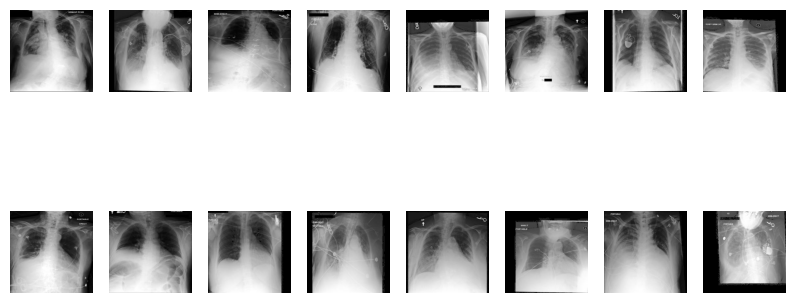

In [26]:
plt.figure(figsize=(10, 10))
for img, label in dataset_val.take(1):
    for n in range(16):
        ax = plt.subplot(4, 8, n+1)
        plt.imshow(img[n], cmap='gray')
        plt.axis("off")

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0     

In [28]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
input_img = Input(input_shape)
x = model(input_img)
predictions = Dense(1, activation="sigmoid")(x)
full_model = Model(inputs=input_img, outputs=predictions)
model.trainable = False

In [29]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 256)               7299904   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,300,161
Trainable params: 257
Non-trainable params: 7,299,904
_________________________________________________________________


## Training

In [31]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='./model/siamese/siamese_proposed_' + current_group + '.h5',monitor='val_loss',save_best_only=True),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3)]
initial_learning_rate = 0.001

In [32]:
full_model.compile(optimizer=opt,loss='binary_crossentropy',
metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

In [33]:
epochs = 50
history = full_model.fit(
    dataset_train,
    validation_data=dataset_val, 
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
)

Epoch 1/50
4059/4059 [==============================] - 250s 58ms/step - loss: 0.3299 - auc: 0.9331 - binary_accuracy: 0.8696 - val_loss: 0.3284 - val_auc: 0.9288 - val_binary_accuracy: 0.8710
Epoch 2/50
4059/4059 [==============================] - 233s 57ms/step - loss: 0.2904 - auc: 0.9452 - binary_accuracy: 0.8880 - val_loss: 0.3227 - val_auc: 0.9307 - val_binary_accuracy: 0.8744
Epoch 3/50
4059/4059 [==============================] - 234s 58ms/step - loss: 0.2858 - auc: 0.9466 - binary_accuracy: 0.8900 - val_loss: 0.3193 - val_auc: 0.9317 - val_binary_accuracy: 0.8759
Epoch 4/50
4059/4059 [==============================] - 239s 59ms/step - loss: 0.2830 - auc: 0.9473 - binary_accuracy: 0.8911 - val_loss: 0.3172 - val_auc: 0.9322 - val_binary_accuracy: 0.8769
Epoch 5/50
4059/4059 [==============================] - 240s 59ms/step - loss: 0.2811 - auc: 0.9478 - binary_accuracy: 0.8921 - val_loss: 0.3161 - val_auc: 0.9324 - val_binary_accuracy: 0.8771
Epoch 6/50
4059/4059 [=============